In [79]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


In [80]:
print(tf.__version__)
tf.config.list_physical_devices('GPU') # 실행하여 GPU가 인식된다면, 자동으로 GPU 연산 가능

2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [81]:
df = pd.read_csv('/home/miserver10/workspace_vscode/datasets/Truck_sales.csv')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Month-Year          144 non-null    object
 1   Number_Trucks_Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [83]:
df.describe

<bound method NDFrame.describe of     Month-Year  Number_Trucks_Sold
0       03-Jan                 155
1       03-Feb                 173
2       03-Mar                 204
3       03-Apr                 219
4       03-May                 223
..         ...                 ...
139     14-Aug                 933
140     14-Sep                 704
141     14-Oct                 639
142     14-Nov                 571
143     14-Dec                 666

[144 rows x 2 columns]>

In [84]:
# Convert 'Month-Year' to datetime format
df['Month-Year'] = pd.to_datetime(df['Month-Year'], format='%y-%b')

# Set 'Month-Year' as the index
df.set_index('Month-Year', inplace=True)

In [85]:
df.head()

,Number_Trucks_Sold
Month-Year,
2003-01-01,155
2003-02-01,173
2003-03-01,204
2003-04-01,219
2003-05-01,223


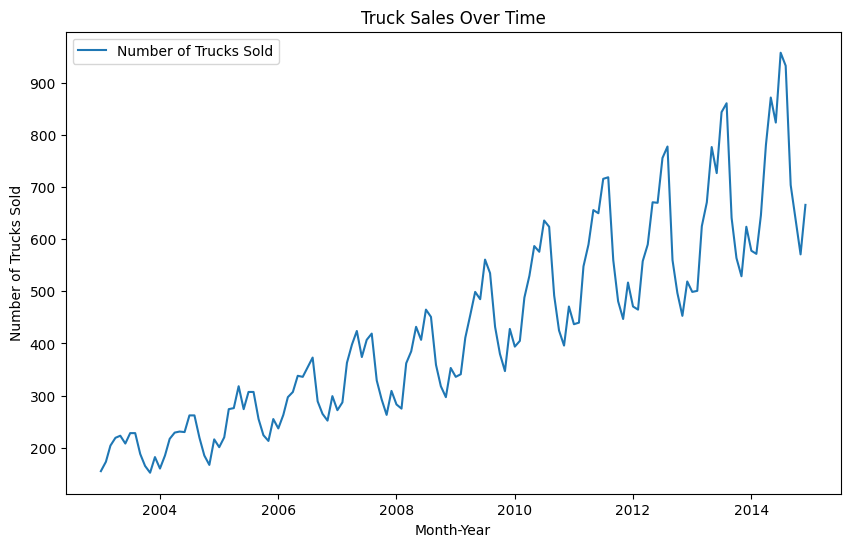

In [86]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['Number_Trucks_Sold'], label='Number of Trucks Sold')
plt.title('Truck Sales Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Trucks Sold')
plt.legend()
plt.show()

In [87]:
# 판매량 스케일링 (0과 1 사이로 변환)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 데이터 분할 (훈련과 테스트)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [88]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# seq : 과거 12개의 데이터, label : 다음 데이터인 label을 예측하고자 학습

sequence_length = 12   # 예: 12개월을 시퀀스 길이로 설정
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [89]:
# RNN 모델 구성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
103/103 [==============================] - 5s 12ms/step - loss: 0.0192
Epoch 2/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0113
Epoch 3/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0105
Epoch 4/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0115
Epoch 5/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0109
Epoch 6/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0096
Epoch 7/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0052
Epoch 8/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0031
Epoch 9/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0052
Epoch 10/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0023
Epoch 11/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0022
Epoch 12/30
103/103 [==============================] - 1s 12ms/step - loss: 0.0015
Epoch 13/30
1

1/1 [==============================] - 0s 27ms/step


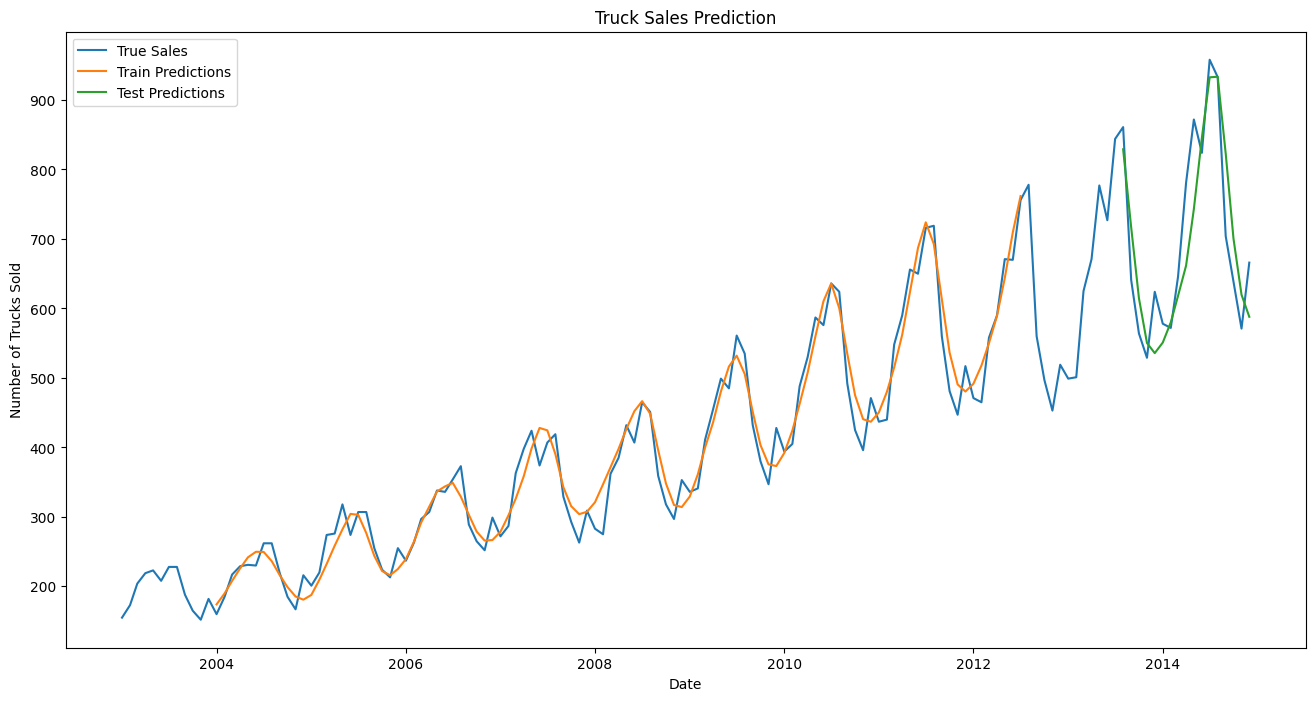

In [90]:
# 예측 수행
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# 원래 스케일로 변환
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 빈 배열 생성
train_predictions_plot = np.empty((len(df), 1))
train_predictions_plot[:, :] = np.nan
test_predictions_plot = np.empty((len(df), 1))
test_predictions_plot[:, :] = np.nan

# 예측값 할당
train_predictions_plot[sequence_length:len(train_predictions) + sequence_length, 0] = train_predictions[:, 0]
test_predictions_plot[sequence_length + len(train_predictions) + sequence_length:len(df) , 0] = test_predictions[:, 0]

# 데이터프레임에 예측값 추가
df['Train Predictions'] = train_predictions_plot
df['Test Predictions'] = test_predictions_plot

# 시각화
plt.figure(figsize=(16, 8))
plt.title('Truck Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Trucks Sold')
plt.plot(df.index, df['Number_Trucks_Sold'], label='True Sales')
plt.plot(df.index, df['Train Predictions'], label='Train Predictions')
plt.plot(df.index, df['Test Predictions'], label='Test Predictions')
plt.legend()
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE 계산
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error (MSE): {mse}')

# MAE 계산
mae = mean_absolute_error(y_test, test_predictions)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 4558.7697176939855
Mean Absolute Error (MAE): 54.94373635684741
